## Mounting of Google Drive

Link Google Drive to Google Colab

 ** **Upload "fake reviews dataset.csv" to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installation of Libraries

Install necessary Libraries

In [2]:
!pip install datasets
! pip install -U accelerate
! pip install -U transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transform

In [3]:
# Import necessary Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset

plt.style.use('dark_background')

## Data Preparation

Prepare the dataset into Hugging Face format for fine tuning the model

In [4]:
# Load the dataset with columns that we will be using
Data_path = '/content/drive/MyDrive/'

df = pd.read_csv(Data_path + 'fake reviews dataset.csv', usecols=['text_', 'label'])

In [5]:
df.head()

,label,text_
0,CG,"Love this! Well made, sturdy, and very comfor..."
1,CG,"love it, a great upgrade from the original. I..."
2,CG,This pillow saved my back. I love the look and...
3,CG,"Missing information on how to use it, but it i..."
4,CG,Very nice set. Good quality. We have had the s...


Since we are using a transformer, we will not do any preprocessing to the raw texts as the tokenizer we downloaded from Hugging Face will process the raw texts to the transformer requirement.

In [6]:
# Encode the label to 0 and 1
df['label'] = df['label'].map(lambda x: 0 if x=='CG' else 1)

df.head()

,label,text_
0,0,"Love this! Well made, sturdy, and very comfor..."
1,0,"love it, a great upgrade from the original. I..."
2,0,This pillow saved my back. I love the look and...
3,0,"Missing information on how to use it, but it i..."
4,0,Very nice set. Good quality. We have had the s...


In [7]:
# Split the dataset into training, validation and testing
test_data = df.sample(frac=0.3, random_state=42)
val_data = df.drop(test_data.index).sample(frac=0.2, random_state=42)
train_data = df.drop(test_data.index).drop(val_data.index)

In [8]:
# Check if all 3 datasets are balanced after spliting
train_data.label.value_counts(normalize=True), val_data.label.value_counts(normalize=True), test_data.label.value_counts(normalize=True)

(0    0.500397
 1    0.499603
 Name: label, dtype: float64,
 1    0.501767
 0    0.498233
 Name: label, dtype: float64,
 0    0.500082
 1    0.499918
 Name: label, dtype: float64)

We will use Hugging Face Dataset generator to convert our datasets into Hugging Face format

In [9]:
# Convert dataset to Hugging Face format
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)

We first take a look at the words distribution of each review in our text data to select max length for each review.

<Axes: >

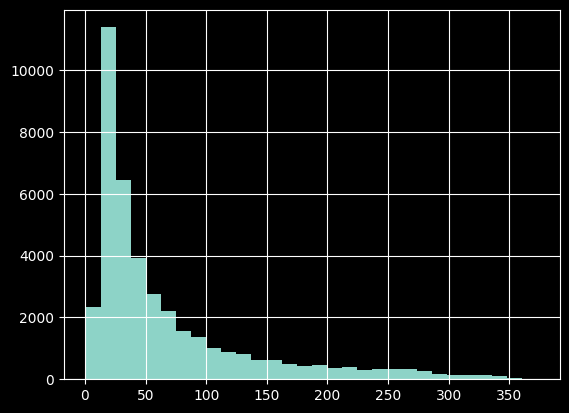

In [10]:
# get length of all the reviews in the dataset
seq_len = [len(i.split()) for i in df['text_']]

pd.Series(seq_len).hist(bins = 30)

Most reviews are having around 50 to 100 words. We will set the review length to 75.

We will the tokenizer from Hugging Face.

In [11]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Write a function to tokenize the data
def tokenize_dataset(data):
    return tokenizer(data["text_"],
                     max_length=75,
                     truncation=True,
                     padding="max_length")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
# Tokenized the dataset for training the model
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_val = hg_val_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/22642 [00:00<?, ? examples/s]

Map:   0%|          | 0/5660 [00:00<?, ? examples/s]

Map:   0%|          | 0/12130 [00:00<?, ? examples/s]

In [13]:
dataset_train

Dataset({
    features: ['label', 'text_', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 22642
})

Download the Distilbert model from Hugging Face.

In [14]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label = {0: "CG", 1: "OR"})

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We will train the model using the "Trainer" class from Hugging Face transformers. Before we start training, we will have to set some hyperparameters that "Trainer" will use for training and evaluation using the "TrainingArgument" class.

In [15]:
# Set hyperparameters for "Trainer" class
training_args = TrainingArguments(
    output_dir="./fine_tune_transformer/",
    logging_dir='./fine_tune_transformer/logs',
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True)

In [16]:
# Create a function for evaluation
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Now create a "Trainer" class object with necessary parameters and start training the model.

In [17]:
# Create the class object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics)

In [18]:
# Start training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.218300,0.291137,0.941519
2,0.102500,0.136989,0.973145
3,0.056400,0.235842,0.963074
4,0.032800,0.271822,0.961661
5,0.016900,0.231495,0.967668


TrainOutput(global_step=28305, training_loss=0.08540464912364686, metrics={'train_runtime': 1526.7799, 'train_samples_per_second': 74.15, 'train_steps_per_second': 18.539, 'total_flos': 2196772588161000.0, 'train_loss': 0.08540464912364686, 'epoch': 5.0})

We are just training for 5 epochs and the model is having over 90% accuracy for every epoch. The “Trainer” class API will know that epoch 2 is the best model as it has the lowest loss and highest accuracy and will use the weights for the prediction. We will evaluate with the validation dataset.

In [19]:
# Evaluate the model using the validation dataset
trainer.evaluate(dataset_val)

{'eval_loss': 0.13698886334896088,
 'eval_accuracy': 0.9731448763250884,
 'eval_runtime': 15.709,
 'eval_samples_per_second': 360.303,
 'eval_steps_per_second': 90.076,
 'epoch': 5.0}

As shown above, the "Trainer" uses the model weights from epoch 2 automatically for evaluation.

Next, evaluate the model using classification report and confusion matrixs with the test dataset.

In [20]:
# Get the prediction
y_pred_logits = trainer.predict(dataset_test)

y_pred_logits[0]

array([[ 3.3641682, -3.82794  ],
       [ 4.2686844, -4.8082657],
       [-4.784409 ,  3.836459 ],
       ...,
       [-5.0867763,  4.056728 ],
       [-4.4179955,  3.4973297],
       [ 4.1955385, -4.725377 ]], dtype=float32)

In [21]:
# Convert the prediction to probabilities using "softmax"
y_pred_probabilities = tf.nn.softmax(y_pred_logits.predictions)

y_pred_probabilities

<tf.Tensor: shape=(12130, 2), dtype=float32, numpy=
array([[9.9924809e-01, 7.5193529e-04],
       [9.9988568e-01, 1.1425653e-04],
       [1.8027124e-04, 9.9981982e-01],
       ...,
       [1.0690061e-04, 9.9989307e-01],
       [3.6497187e-04, 9.9963498e-01],
       [9.9986649e-01, 1.3354806e-04]], dtype=float32)>

In [22]:
# Get the prediction label - 0 or 1
pred_label = np.argmax(y_pred_probabilities, axis=1)

In [23]:
# Classification Report
print(classification_report(dataset_test['label'], pred_label))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6066
           1       0.98      0.96      0.97      6064

    accuracy                           0.97     12130
   macro avg       0.97      0.97      0.97     12130
weighted avg       0.97      0.97      0.97     12130



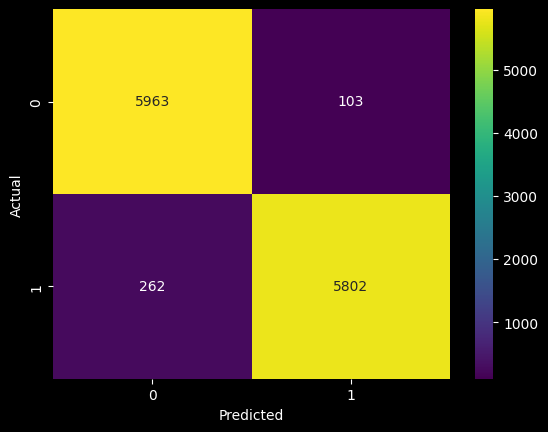

In [24]:
# Confusion Matrix
sns.heatmap(confusion_matrix(dataset_test['label'], pred_label), annot=True, fmt='d', cmap='viridis')

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

The model achieves 97% accuracy with the test dataset. The confusion matrix also shows that the model can classify each label very well. We will save this model for future deployment if necessary. Only the best model (which is epoch 2) will be saved.

In [25]:
# Save the model
trainer.save_model('./best_model/')